# Для корректной работы проекта необходимо выгружать папку с архивом в корневой каталог вашего гугл драйва

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup as BS
import bs4

In [ ]:
raw_html = open(
    '/content/drive/MyDrive/IvAnn/messages.html', 
    'r'
).read()
soup = BS(raw_html)

In [ ]:
import re

def extract_message_num(reference):
  '''
  эта функция из сообщения типа #go_to_message1048 делает число 1047
  '''
  return int(re.findall('\d+', reference)[0])

def is_throw(message):
  '''
  по ключевым фразам определяем с помощью регулярок срывы
  '''
  if (re.search(r"я выпил", message) 
  or re.search(r"я сорвался", message)
  or re.search(r"я на грани", message)
  or re.search(r"мне нужна помощь", message)
  or re.search(r"я срывался", message)
  or re.search(r"умирать хочу", message)
  or re.search(r"сорвался вчера", message)
  or re.search(r"недавно сорвалась", message)
  or re.search(r"помогите пожалуйста", message)
  or re.search(r"мне очень нужна поддержка", message)
  or re.search(r"сегодня пьян", message)
  or re.search(r"я погибаю", message)
  or re.search(r"мне плохо", message)
  or re.search(r"я плакать хочу", message)
  or re.search(r"запил опять", message)
  or re.search(r"хочется избавиться", message)
  or re.search(r"хочу завязать", message)
  or re.search(r"произошел срыв", message)
  or re.search(r"я сорвал", message)
  or re.search(r"помогите прошу", message)): 
    return True
  return False

def is_help(message):
  '''
  по ключевым фразам определяем с помощью регулярок сообщения поддержки
  '''
  if (re.search(r"держись", message) 
  or re.search(r"понимаю твои чувства", message)
  or re.search(r"поддержка", message)
  or re.search(r"сил тебе", message)
  or re.search(r"расскажи как", message)
  or re.search(r"ты справишься", message)
  or re.search(r"ты сможешь", message)
  or re.search(r"такое бывало", message)
  or re.search(r"возвращайся", message)
  or re.search(r"иди на группу", message)
  or re.search(r"береги", message)
  or re.search(r"советую", message)
  or re.search(r"пиши мне", message)
  or re.search(r"получится", message)
  or re.search(r"ты не одинок", message)
  or re.search(r"нас много", message)
  or re.search(r"понимаю", message)
  or re.search(r"расскажи", message)
  or re.search(r"знакомо", message)
  or re.search(r"ты в нужном месте", message)
  or re.search(r"сходи на группу", message)
  or re.search(r"желаю сил", message)): 
    return True
  return False

def select_message_type(message):
  '''
  на входе - сообщение, на выходе - тип сообщения
  '''
  if is_help(message):
    return "поддержка"
  if is_throw(message):
    return "срыв"
  return "иное"

def extract_info_from_div(div_elem):
  '''
  эта функция достает информацию из элементов html типа такого

  <div class="body">
  <div class="pull_right date details" title="11.03.2022 19:23:24 UTC+03:00">
  19:23
       </div>
  <div class="from_name">
  Н Гузель
       </div>
  <div class="text">
  В чате недопустимы мат, оскорбления, спам, флуд, политика, провокации, пропаганда, диагнозы, оценки, обсуждение веществ изменяющих сознание и мед.препаратов, навязывание точки зрения.
       </div>
  </div>
  '''
  info = {
    'timestamp' : None,
    'author' : None, 
    'message' : None,
    'message_type' : None,
    'has_media': False,
    'reply_to' : None
  }

  MESSAGE_TYPES = ['поддержка',
                    'модератор',
                    'срыв',
                    'прочее']

  author = div_elem.find('div', class_='from_name')
  if author:
    info['author'] = author.text.strip()
  else:
    info['author'] = "mod" # если автора у сообщения нет, то он становится mod

  reply = div_elem.find('div', class_='reply_to')
  if reply:
    info['reply_to'] = extract_message_num(reply.a['href'])

  if div_elem.find('div', class_='status'):
    info['has_media'] = True

  time = div_elem.find('div', 
          class_='date')
  if time:
    info['timestamp'] = pd.to_datetime(time['title'])

  message = div_elem.find('div', class_='text')
  if message:
    info['message'] = message.text.strip().lower()
    if (info['author'] == "mod" or "AA-Online.ru" in info['author']): #исключаем главных модераторов бесед из возможных сообщений о срывах
      message_type = "иное"
    else:
      if len(message.text.strip()) < 300: # обычные пользователи не пишут огромные сообщения
        message_type = select_message_type(str(message))
      else:
        message_type = "иное"
      info['message_type'] = message_type


  if not message and not author and not info['has_media']:
    info['message'] = div_elem.text.strip()
  
  return info

In [ ]:
def count_words(dataframe, minchars = 4):
  '''
  функция подсчитывания слов в датафрейме, на выходе - график сообщений
  '''
  words = dict() # создаем словарь слов
  for index, row in dataframe.iterrows(): 
    if row['message']: # если сообщение не пустое
      for word in ' '.join(w for w in re.split(r"\W", row['message']) if w).split(): # убираем все знаки препинания из предложения и смотрим слова
        if len(word) > minchars: 
          if word in words: # суём слово в словарь, если его нет, или прибавляем 1 к числу его появлений
            words[word] += 1
          else:
            words[word] = 0
  words = dict(sorted(words.items(), key=lambda item: item[1])) #сортируем слова по частоте появления
  dfwords = pd.DataFrame(data = words, index = ['count']).transpose().tail(25).plot(kind='pie',subplots=True, figsize=(30, 15), legend=False, autopct='%1.1f%%') # рисуем круговую диаграмму


In [ ]:
data = [extract_info_from_div(div) for div 
        in soup.html.body.find_all('div', class_='body')] # достаем сообщения по одному из html-файла и красиво засовываем их в лист

df1 = pd.DataFrame.from_dict(data) # переделываем лист в датафрейм

In [ ]:
data2 = []

for i in range(2,88): # max 87, пробегаемся по всем отдельным файлам, которые дал телеграм
  print('parsing messages' + str(i))
  raw_html2 = open(
      '/content/drive/MyDrive/IvAnn/online-ru/messages' + str(i) + '.html', 
      'r'
  ).read()
  soup2 = BS(raw_html2)

  data2 = data2 + [extract_info_from_div(div) for div 
          in soup2.html.body.find_all('div', class_='body')]

df2 = pd.DataFrame.from_dict(data2)

parsing messages2
parsing messages3
parsing messages4
parsing messages5
parsing messages6
parsing messages7
parsing messages8
parsing messages9
parsing messages10
parsing messages11
parsing messages12
parsing messages13
parsing messages14
parsing messages15
parsing messages16
parsing messages17
parsing messages18
parsing messages19
parsing messages20
parsing messages21
parsing messages22
parsing messages23
parsing messages24
parsing messages25
parsing messages26
parsing messages27
parsing messages28
parsing messages29
parsing messages30
parsing messages31
parsing messages32
parsing messages33
parsing messages34
parsing messages35
parsing messages36
parsing messages37
parsing messages38
parsing messages39
parsing messages40
parsing messages41
parsing messages42
parsing messages43
parsing messages44
parsing messages45
parsing messages46
parsing messages47
parsing messages48
parsing messages49
parsing messages50
parsing messages51
parsing messages52
parsing messages53
parsing messages54
p

,timestamp,author,message,message_type,has_media,reply_to
2251,2022-11-10 01:32:06-03:00,Daniela Izbisciuc,пару раз получилось …но сейчас нет… я на грани…,срыв,False,NaN
2254,2022-11-10 01:33:54-03:00,Daniela Izbisciuc,я почти что умирать хочу…..правда..да я сильна...,срыв,False,NaN


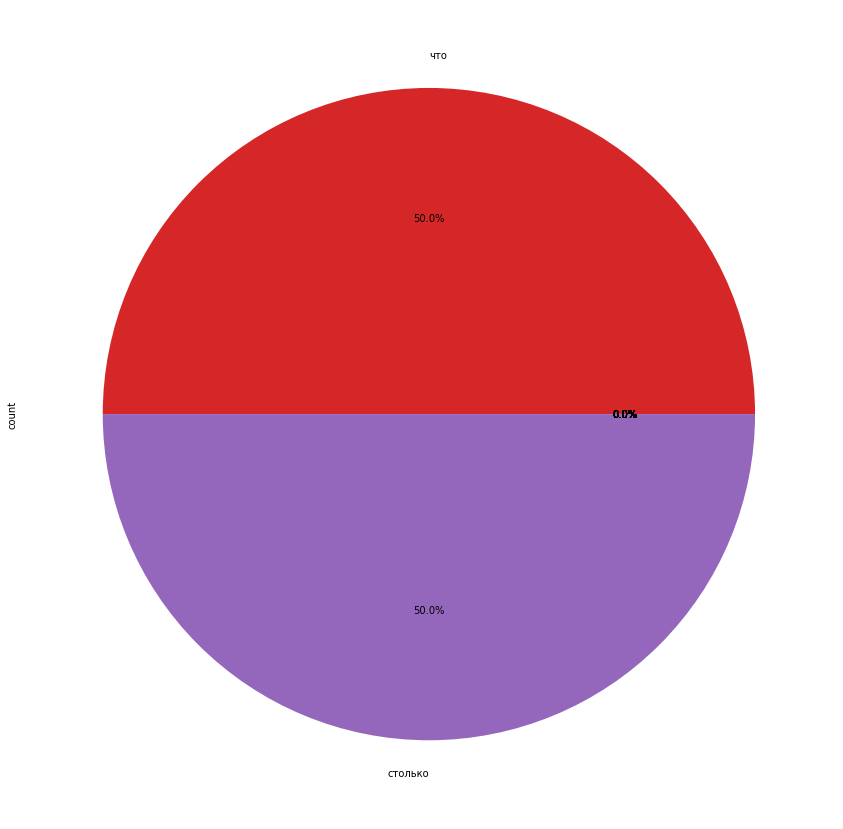

In [ ]:
count_words(df1.query("message_type == 'срыв'"), minchars = 2)
df1.query("message_type == 'срыв'")

,timestamp,author,message,message_type,has_media,reply_to
153,2022-03-15 23:49:26-03:00,Lisa,я медсестра и немного в медицине понимаю. дума...,поддержка,False,148.0
473,2022-04-13 16:53:57-03:00,Н Гузель,"тебя никто не заставляет, не понимаю зачем нам...",поддержка,False,NaN
816,2022-12-05 23:40:34-03:00,Irina,доброй ночи. я не знаю правил чата и не смогла...,поддержка,False,NaN
870,2022-05-16 23:01:17-03:00,Вячеслав Б.,"понял, спасибо! в этой главе только это предло...",поддержка,False,839.0
971,2022-05-23 10:50:26-03:00,Оксана,на самом деле не люблю пользоваться властью. я...,поддержка,False,NaN
1662,2022-08-08 12:00:12-03:00,Вячеслав Б.,"группы аа не только как поддержка работают, эт...",поддержка,False,1558.0
1668,2022-08-08 12:25:35-03:00,Марина,просто полтора года назад получилось всё вмест...,поддержка,False,1564.0
2153,2022-09-26 23:47:17-03:00,Roman Leonov,"у меня по разному было... от дня до трёх, иног...",поддержка,False,2000.0
2243,2022-11-10 01:29:12-03:00,Daniela Izbisciuc,привет всем!!!мне очень нужна помощь и поддержка…,поддержка,False,NaN
2777,2022-12-28 20:22:31-03:00,илья,держись и больше не пейто что ты сорвался не з...,поддержка,False,NaN


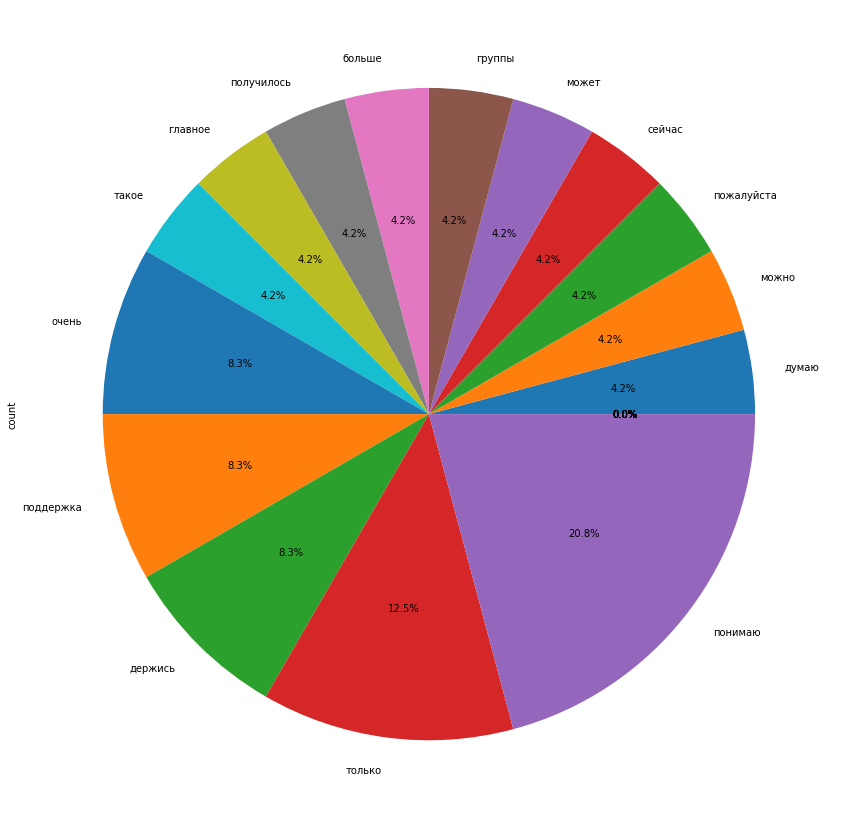

In [ ]:
count_words(df1.query("message_type == 'поддержка'"), minchars = 4)
df1.query("message_type == 'поддержка'")

,timestamp,author,message,message_type,has_media,reply_to
5201,2020-09-20 10:03:17-03:00,Rodion K,потому что он подшивал на год а я сорвался чер...,срыв,False,NaN
7861,2020-09-23 09:19:02-03:00,Deleted Account,я сорвался.,срыв,False,NaN
10688,2020-09-29 23:59:57-03:00,ManDarina🍊🎄,"меня спасает только страх похмелья , один раз ...",срыв,False,NaN
14535,2020-10-19 22:30:31-03:00,Daria D,я сорвалась,срыв,False,NaN
15490,2020-10-27 10:42:32-03:00,Алена Алена,одна недавно сорвалась.уехала в гости хз к ком...,срыв,False,NaN
21993,2020-04-12 00:18:05-03:00,Тюльпан,мне плохо я плакать хочу,срыв,False,NaN
22543,2020-08-12 16:08:20-03:00,Тюльпан,"всем доброго времени, мне плохо от того как ис...",срыв,False,NaN
24749,2020-12-29 19:16:33-03:00,С Ж,"всем привет , помогите пожалуйста , скиньте по...",срыв,False,NaN
26740,2021-01-14 02:28:51-03:00,AsvPin,"слушайте, такой вопрос. три года назад был мой...",срыв,False,NaN
26854,2021-01-14 21:26:39-03:00,ЕвгенийЧе,"ребят голова прошла после собрания, ну и лекар...",срыв,False,NaN


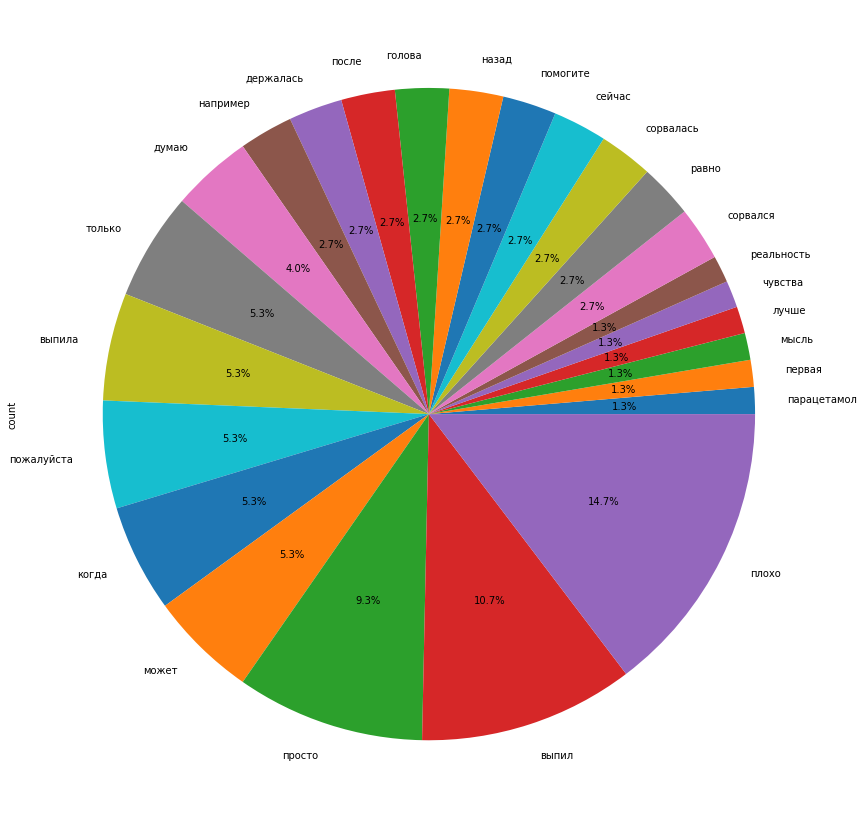

In [ ]:
count_words(df2.query("message_type == 'срыв'"), minchars = 4)
df2.query("message_type == 'срыв'")

,timestamp,author,message,message_type,has_media,reply_to
2,2020-03-07 15:48:53-03:00,Tatiana,всем привет! я чего-то не понимаю или пропусти...,поддержка,False,NaN
20,2020-03-07 16:34:56-03:00,Natali,отличное решение👍поддержка тебе,поддержка,False,1173.0
1288,2020-02-08 20:05:43-03:00,Sergey K*,"посмотрите другую группу поближе, там есть адр...",поддержка,False,NaN
1557,2020-06-08 23:07:23-03:00,Alina L,"юрий, сходи на группу, там я нашла ответы на м...",поддержка,False,NaN
1589,2020-06-08 23:17:24-03:00,Deleted Account,опять мысль. понимаю заслуги и унижение не спо...,поддержка,False,NaN
...,...,...,...,...,...,...
97977,2021-10-11 09:13:02-03:00,Оля Смоля,и первые недели 3 самые важные и радостные. в ...,поддержка,False,98080.0
98038,2021-10-11 11:08:40-03:00,❤️❤️ ❤️,"сама не знаю что мне необходимо,мне нужно как ...",поддержка,False,98136.0
98120,2021-10-11 17:46:17-03:00,Алесандр,"конечно нет.вокруг меня много верующих людей, ...",поддержка,False,98210.0
98143,2021-10-11 18:06:12-03:00,Оля Смоля,"поддержка тебе ✊ молодчина, я вобще не понимаю...",поддержка,False,98242.0


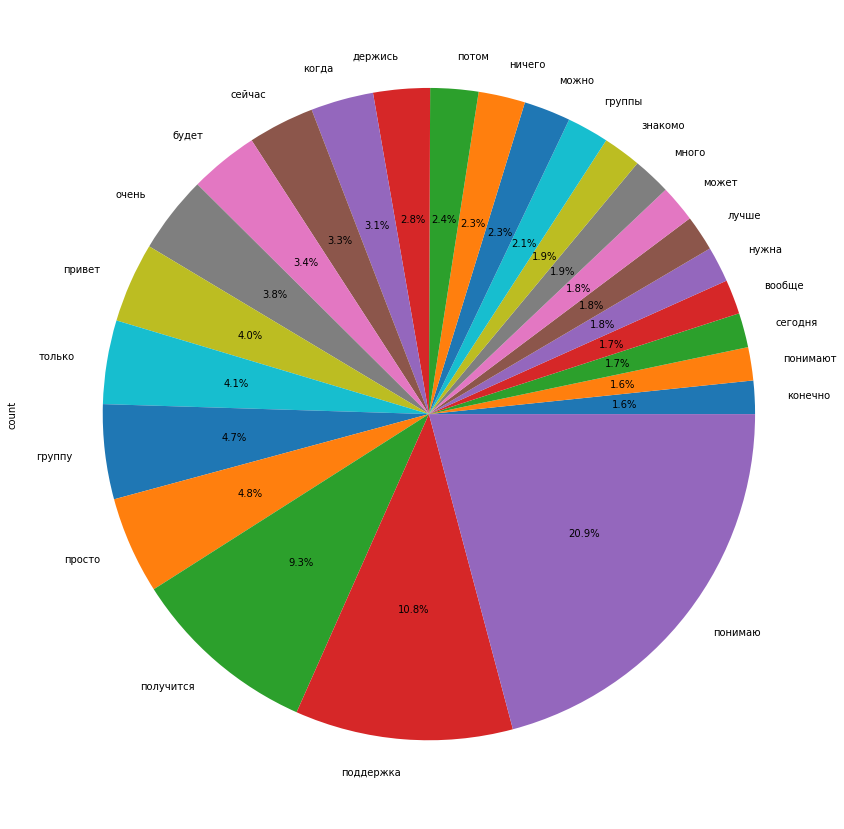

In [ ]:
count_words(df2.query("message_type == 'поддержка'"), minchars = 4)
df2.query("message_type == 'поддержка'")